# NEXUS tool: case study for the Souss-Massa basin - energy demand calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [170]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
%autoreload
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
from nexus_tool.weap_tools import create_learning_curve
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

In [162]:
scenarios = ['Reference']
load_folder = os.path.join('Data - Souss-Massa', 'Merged data')
results_folder = os.path.join('Morocco dashboard', 'data')
create_folder(results_folder)
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
            
            #Define the path to read the scenario input data and reads it in
            file_path = os.path.join(load_data, 'demand_data.csv')
            df = nexus_tool.read_csv(file_path)
            
            #Creates the nexus model with the input dataframe
            souss_massa = nexus_tool.Model(df)
            
            #Define the diameter of the pipelines. The first is general for all and the following specific for each case
            souss_massa.df['Pipe_diameter'] = 0.4
            souss_massa.df.loc[souss_massa.df['type'].str.contains('GW'), 'Pipe_diameter'] = 0.6
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Pipeline'), 'Pipe_diameter'] = 1
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), 'Pipe_diameter'] = 1
            
            #Define the variable to take into account for elevation difference and lenght of pipelines
            souss_massa.elevation = 'elevation_diff' #for the case of GW, the elevation_diff is set to be the wtd
            souss_massa.L = 'distance' #for the case of GW, the distance is set to be the wtd
            
            #Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
            souss_massa.pwd = 'pwd'
            souss_massa.sswd = 'sswd'
            souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
            souss_massa.peak_Q = souss_massa.pwd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.avg_Q = souss_massa.sswd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.swpp_e = 'swpp_e'
            souss_massa.pd_e = 'swpp_e'
            souss_massa.swpa_e = 'swpa_e'
            souss_massa.pumping_hours_per_day = 10
            souss_massa.SWpump_eff = 0.6
            
            #Defines the PWD. It is defined as double the seasonal demand for agricultural sites
            souss_massa.df[souss_massa.pwd] = souss_massa.df[souss_massa.sswd] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
            souss_massa.df.loc[souss_massa.df['type']=='Agriculture', souss_massa.pwd] *= 2
            
            #Calculates some required parameters
            souss_massa.get_A(inplace=True)
            souss_massa.get_V(inplace=True, axis=0)
            souss_massa.get_Re(inplace=True, axis=0)
            souss_massa.get_f(inplace=True, axis=0)

            souss_massa.get_sw_tdh(inplace = True, axis=0) #this is called sw but it calculets for gw too. I still need to change the names
            souss_massa.get_SWpumping_energy(inplace = True, axis=0) #the same here
            
            souss_massa.df.loc[souss_massa.df.swpp_e<0, souss_massa.swpp_e] = 0
            souss_massa.df.loc[souss_massa.df.swpa_e<0, souss_massa.swpa_e] = 0
            
            #Define energy intensity for seawater desalination project
            desalination_energy_int = 3.31 # kWh/m3
            #We compute the energy demand for deslination multiplying the monthly water requirement by the energy intensity, 
            #and add it to the current energy requirements for desalinated water pumping
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] += \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.sswd] * \
                                    desalination_energy_int
            #Then we divide the total energy requiered for desalination by the daily pumping hours and the days of the month
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpp_e] = \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] / \
                                    souss_massa.pumping_hours_per_day / 30 #30 days per month

            #Here we load the WWTP inflow data
            file_path = os.path.join(load_data, 'wwtp_inflow.csv')
            df_wwtp = pd.read_csv(file_path)
            
            #We define an energy intensity for wastewater treatment and compute the energy demand
            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int
            
            
            #From here onwards we calculate the LCOE method. It is working at the moment for 
            #the demand points of the schematic but I need to change it for the GIS cropland and built-up areas
            
            #Define the path to read the cropland and builtup are data and reads it in
            folder_path = os.path.join('Data - Souss-Massa', 'Cropland and Builtarea')
            cropland_path = os.path.join(folder_path, 'cropland.csv')
            cropland = nexus_tool.read_csv(cropland_path)
            cropland = cropland.loc[cropland.Date.isin(souss_massa.df.Date.unique())]
            builtareas_path = os.path.join(folder_path, 'builtarea.csv')
            builtareas = nexus_tool.read_csv(builtareas_path)
            builtareas = builtareas.loc[builtareas.Date.isin(souss_massa.df.Date.unique())]
            
            summary_provinces_domestic = souss_massa.df.loc[souss_massa.df['type'].str.contains('Domestic')].groupby(['Province', 'Date'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
            summary_provinces_agri = souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')].groupby(['Province', 'Date'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
            temp_cropland_provinces = cropland[['province', 'Date']].copy()
            temp_cropland_provinces.loc[temp_cropland_provinces['province']=='Inezgane-Aït Melloul', 'province'] = 'Taroudannt'
            temp_builtareas_provinces = builtareas[['province', 'Date']].copy()
            temp_builtareas_provinces.loc[temp_builtareas_provinces['province']=='Inezgane-Aït Melloul', 'province'] = 'Agadir-Ida ou Tanane'
            for feature in list(summary_provinces_agri):
                cropland[feature] = temp_cropland_provinces.set_index(['province', 'Date']).index.map(summary_provinces_agri[feature]) * cropland['area_share']
                builtareas[feature] = temp_builtareas_provinces.set_index(['province', 'Date']).index.map(summary_provinces_domestic[feature]) * builtareas['area_share']
            
            sm_cropland = nexus_tool.Model(cropland)
            
            sm_cropland.start_year = 2020
            sm_cropland.end_year = 2050
            sm_cropland.discount_rate = 0.05
            sm_cropland.pwd = 'pwd'
            sm_cropland.sswd = 'sswd'
            sm_cropland.pd_e = 'swpp_e'
            sm_cropland.swpp_e = 'swpp_e'
            sm_cropland.swpa_e = 'swpa_e'
            
            sm_cropland.create_wind_turbine('Wind power', life=20,
                                            om_cost=0.02, capital_cost=1250,
                                            efficiency=1)
            sm_cropland.technologies['Wind power'].p_rated = 80
            sm_cropland.technologies['Wind power'].p_curve = [0, 0, 0, 0, 2.9, 6, 11, 17.7, 27.3, 39.2, 51.4, 63.8, 74.2, 79.9, 82.2, 82.9, 83.3, 83.3, 83, 83, 83]
            sm_cropland.technologies['Wind power'].u_arr = range(0, 21)
            sm_cropland.technologies['Wind power'].z = 39
            
            sm_cropland.create_pv_system('Solar PV', life=15,
                                         om_cost=0.01, capital_cost=500,
                                         efficiency=1)
            
#             sm_cropland.create_standard_tech('Diesel set', life=10, om_cost=0.1,
#                                              capital_cost=938, fuel_cost=0.3,
#                                              fuel_req=0.095, efficiency=0.27, cf = 0.5,
#                                              emission_factor=2.7, env_cost=0)
            
            sm_cropland.create_standard_tech('Grid pump', life=15, om_cost=0.1,
                                             capital_cost=0, fuel_cost=0.2,
                                             fuel_req=1, efficiency=0.85, cf = 0.8,
                                             emission_factor=1.76, env_cost=0)
            
#             np.random.seed(1)
#             souss_massa.df['wind'] = np.random.randint(5,15,souss_massa.df.shape[0])
#             souss_massa.df['srad'] = np.random.randint(22000,50000,souss_massa.df.shape[0])
            
            sm_cropland.get_cf('all', axis=0)
            sm_cropland.get_installed_capacity('all', axis=0)
            sm_cropland.get_max_capacity('a', axis=0)
            sm_cropland.get_lcoe(years='all', axis=0)
            
            sm_cropland.get_least_cost(technologies='a', years='all', axis=0)
            
            souss_massa.df.to_csv(os.path.join(output_folder, 'results.csv'), index=False)
            sm_cropland.lcoe.reset_index().to_csv(os.path.join(output_folder, 'lcoe.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)

In [105]:
sm_cropland.df['Demand point'].max()

7712

In [106]:
souss_massa.df.head()

,Date,Supply point,Year,Month,links,sswd,Demand point,type,wtd,elevation_diff,...,distance,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0


In [6]:
year = 2020
water = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].sswd.sum()
energy = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].swpa_e.sum()

In [7]:
energy/water

0.5732236131284019

In [8]:
souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df.type.str.contains('Domestic'))].groupby(['Year','Demand point']).agg({'sswd': 'sum','swpa_e': 'sum', 'type': 'first'})

sswd         swpa_e         type
Year Demand point                                              
2020 AEP Rural         0.000000e+00       0.000000  GW Domestic
     AEP Taroudant     5.985467e+06  778632.116336  GW Domestic
     AEPR              2.737500e+01       5.581882  GW Domestic
     AEPR 2            2.737500e+01      10.204745  GW Domestic
     AEP_Aoulouz       4.104113e+05   57239.113846  GW Domestic
     AEP_Ighrem        1.743340e+05   78754.545357  GW Domestic
     AEP_SEl Guerdane  2.873562e+05       0.000000  SW Domestic
     AEP_Taliouine     6.065371e+05   84592.605354  GW Domestic
     AEP_ouled berhil  5.992730e+05   77888.650395  GW Domestic
     Agadir            5.163573e+07       0.000000  GW Domestic
     Ait Baha          1.815976e+05       0.000000  SW Domestic
     Biougra           4.278443e+06  947361.805594  GW Domestic
     Lakhssass         1.561740e+05       0.000000  SW Domestic
     Ouled Teima       5.099266e+06  663171.574421  GW Domestic
     Sidi Ifni         7.518153e+05       0.000000  GW Domestic
     Tafraout          1.852300e+05       0.000000  SW Domestic
     Tiznit            4.060531e+06       0.000000  SW Domestic

In [110]:
sm_cropland.technologies

{'Wind power': <nexus_tool.Model.WindTurbine at 0x22879715790>,
 'Solar PV': <nexus_tool.Model.PVSystem at 0x228185663a0>,
 'Grid pump': <nexus_tool.Model.Technology at 0x22879715af0>}

### From here you will find some code to explore the LCOE results:

In [111]:
sm_cropland.lcoe.dropna()

province  water demand  required capacity  \
Demand point Year                                                      
0            2020  Chtouka-Aït Baha  40453.801278           3.169988   
             2021  Chtouka-Aït Baha  32585.498199           2.637680   
             2022  Chtouka-Aït Baha  20830.284875           2.236927   
             2023  Chtouka-Aït Baha  16545.463078           3.073334   
             2024  Chtouka-Aït Baha  18100.094825           2.992033   
...                             ...           ...                ...   
7578         2046            Tiznit   7488.808798           1.695312   
             2047            Tiznit   8331.944002           1.711480   
             2048            Tiznit   8407.774751           1.727586   
             2049            Tiznit   7863.420227           1.742451   
             2050            Tiznit   6316.243395           1.686227   

                   energy demand least_cost_technology      lcoe  
Demand point Year                                                 
0            2020    4938.152607             Grid pump  0.351696  
             2021    3304.679545             Grid pump  0.362867  
             2022    3213.587765             Grid pump  0.368902  
             2023    3572.642982             Grid pump  0.374442  
             2024    3605.212128             Grid pump  0.383961  
...                          ...                   ...       ...  
7578         2046    2807.444289              Solar PV  0.255127  
             2047    3129.374751              Solar PV  0.249909  
             2048    3174.938579              Solar PV  0.248720  
             2049    3019.706553              Solar PV  0.244211  
             2050    2491.219025              Solar PV  0.196592  

[234949 rows x 6 columns]

In [112]:
souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')&(souss_massa.df.Year==2030)].groupby(['Province', 'Year']).sum()

,,Month,sswd,wtd,elevation_diff,distance,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e
Province,Year,,,,,,,,,,,,,,
Agadir-Ida ou Tanane,2030,78,1.263234e+07,0.000000,0.000000,0.000000,4.8,11.696608,1.507964,93.078652,0.037231,0.056324,0.000000,0.000000e+00,0.000000e+00
Chtouka-Aït Baha,2030,468,9.709240e+07,1754.439367,1754.439367,1754.439367,36.0,89.900367,14.702654,617.961426,0.262775,0.282976,1772.779182,1.851936e+04,5.555809e+06
Taroudannt,2030,1404,6.040173e+08,6084.239551,6084.239551,6084.239551,110.4,559.275253,45.992916,2778.141585,1.378845,0.970820,8348.927947,1.103347e+06,3.310040e+08
Tiznit,2030,78,5.058513e+07,682.710362,682.710362,682.710362,7.2,46.838084,3.392920,165.655836,0.099394,0.078402,788.913087,5.338266e+04,1.601480e+07


In [9]:
year = 2020
water = souss_massa.df.loc[souss_massa.df.Year==year, 'sswd'].sum()/1000000
energy = souss_massa.df.loc[souss_massa.df.Year==year,'swpa_e'].sum()/1000000
print('Water demand [Mm3]: ' + str(water),
      '\nEnergy demand [GWh]: ' + str(energy),
      '\nEnergy intensity [kWh/m3]: ' + str(energy/water))

Water demand [Mm3]: 982.9000014077241 
Energy demand [GWh]: 739.4527907380555 
Energy intensity [kWh/m3]: 0.7523174175185676


In [ ]:
souss_massa.df.groupby('type')

In [113]:
sm_cropland.lcoe.reset_index().loc[sm_cropland.lcoe.reset_index().Year==2030].groupby(['province', 'Year']).sum()

,,Demand point,water demand,required capacity,energy demand,lcoe
province,Year,,,,,
Agadir-Ida ou Tanane,2030,1024497,1.263234e+07,0.000000,0.000000e+00,0.000000
Chtouka-Aït Baha,2030,2172570,9.709240e+07,4104.136202,5.555809e+06,1131.908360
Inezgane-Aït Melloul,2030,1334706,4.088542e+07,21227.420495,2.240539e+07,194.830108
Taroudannt,2030,24651484,5.631319e+08,292374.059897,3.085987e+08,1695.538097
Tiznit,2030,558071,5.058513e+07,8955.266648,1.601480e+07,17.870661


### The following block creates a plot grid displaying a parameter for each demand point (with demand), the parameter can be `water demand`, `energy demand`, `lcoe` or `required capacity`
You can uncomment the `sharey=True` line, if you whant to see the same scale in the `y` axis for all of the plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022818900A90>,
      dtype=object)

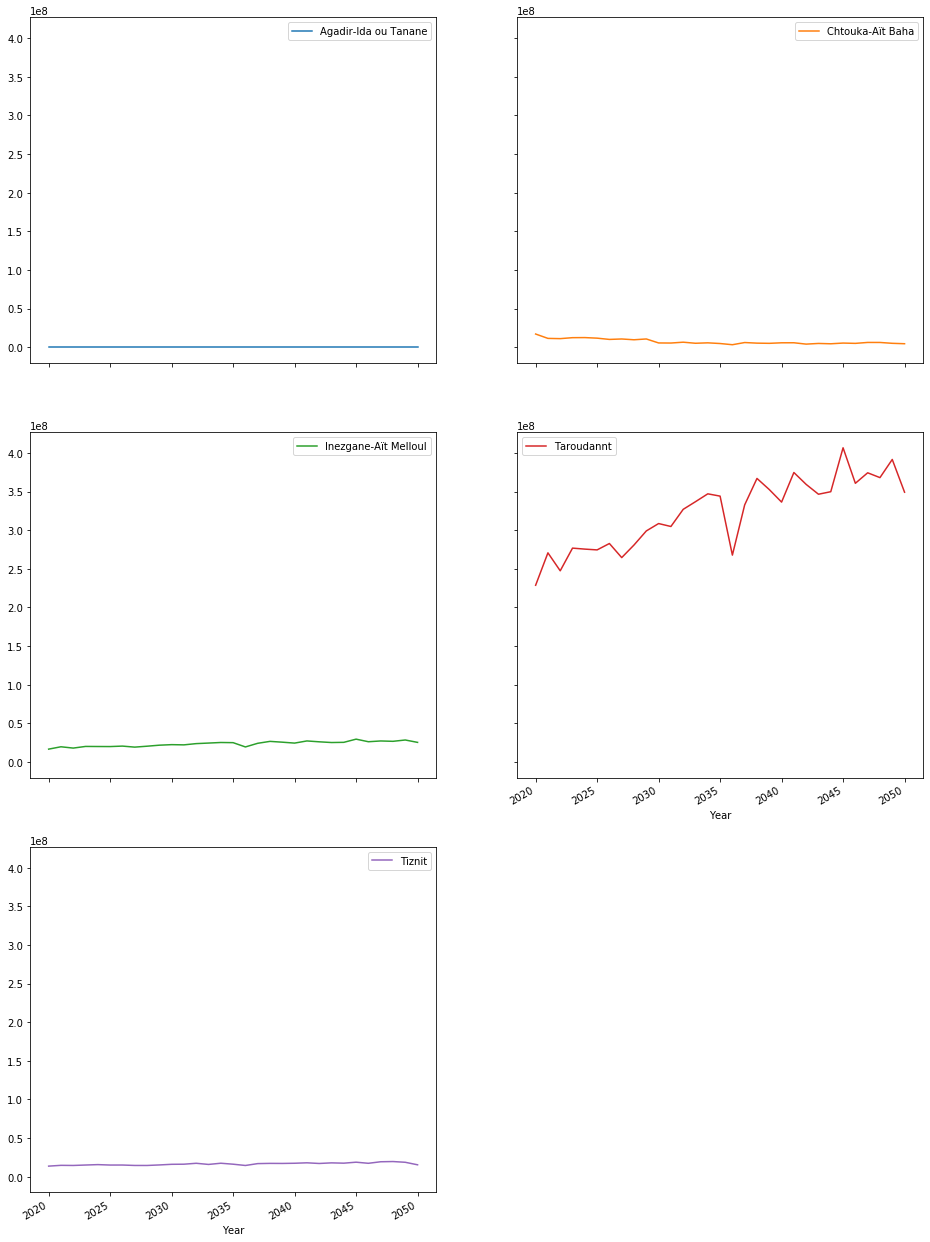

In [131]:
dff = sm_cropland.lcoe.reset_index().groupby(['province', 'Year']).sum().reset_index().dropna().pivot('Year','province','energy demand')
amount = dff.columns.shape[0] + 1
dff.plot(subplots=True,
         layout=(int(amount/2), 2),
         figsize=(16,24),
         sharey=True
        )

In [154]:
df = sm_cropland.technologies['Grid pump'].lcoe
df.loc[df.year==2020].lcoe.min()
# inx = df.loc[(df.year==2020)&(df.lcoe>=1)].index
# df.loc[(df.year==2020)&(df.lcoe<=0.14)]

0.2352941176470586

In [91]:
sm_cropland.df.loc[sm_cropland.df['Demand point'].isin(inx)].isna().sum()

Year            0
Demand point    0
province        0
area_m2         0
Month           0
srad            0
wind            0
Date            0
area_share      0
sswd            0
pwd             0
swpa_e          0
swpp_e          0
dtype: int64

In [85]:
sm_cropland.df.loc[sm_cropland.df['Demand point'].isin(inx)&(sm_cropland.df.Year==2020)].groupby('Demand point').agg({'Year': 'first',
                                                                                                                      'area_m2': 'first',
                                                                                                                      'srad': 'mean',
                                                                                                                      'wind': 'mean',
                                                                                                                      'area_share': 'first',
                                                                                                                      'sswd': 'sum',
                                                                                                                      'pwd': 'max',
                                                                                                                      'swpa_e': 'sum',
                                                                                                                      'swpp_e': 'max'})

,Year,area_m2,srad,wind,area_share,sswd,pwd,swpa_e,swpp_e
Demand point,,,,,,,,,
2082,2020,2.998476,18178.583333,3.308333,1.353770e-08,1.898071,2.979803e-07,0.231695,0.000149
2647,2020,32.360805,18327.083333,3.475000,4.821697e-08,27.512977,5.007232e-06,11.829261,0.012316
2648,2020,2.212805,18327.083333,3.475000,3.297036e-09,1.881314,3.423903e-07,0.808875,0.000842
7464,2020,17.979538,18851.333333,3.025000,2.678916e-08,15.286103,2.781999e-06,6.572292,0.006843
7465,2020,17.979538,18851.333333,3.025000,2.678916e-08,15.286103,2.781999e-06,6.572292,0.006843
7466,2020,49.723760,18705.250000,2.925000,7.408744e-08,42.274865,7.693826e-06,18.176166,0.018924
7467,2020,49.723760,18705.250000,2.925000,7.408744e-08,42.274865,7.693826e-06,18.176166,0.018924
7468,2020,19.138156,18705.250000,2.925000,2.851548e-08,16.271154,2.961274e-06,6.995816,0.007284
7469,2020,19.138157,18705.250000,2.925000,2.851548e-08,16.271154,2.961274e-06,6.995817,0.007284


In [106]:
df = sm_cropland.lcoe.dropna()
df.reset_index().pivot('Year','Demand point','least_cost_technology')

Demand point,0,1,2,3,4,5,6,7,8,9,...,7569,7570,7571,7572,7573,7574,7575,7576,7577,7578
Year,,,,,,,,,,,,,,,,,,,,,
2020,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2021,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2022,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2023,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2024,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2025,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2026,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2027,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2028,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV


In [163]:
import geopandas as gpd

cropland = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200218_clean.csv", encoding='utf-8')

In [164]:
import contextily as ctx

In [165]:
df = sm_cropland.lcoe.reset_index()

df = df.loc[(df.Year==2030)]
df['geometry'] = df['Demand point'].map(cropland.geometry)
df = gpd.GeoDataFrame(df, crs='epsg:26192')
df.to_crs('epsg:3857', inplace=True)
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
provinces.to_crs('epsg:3857', inplace=True)

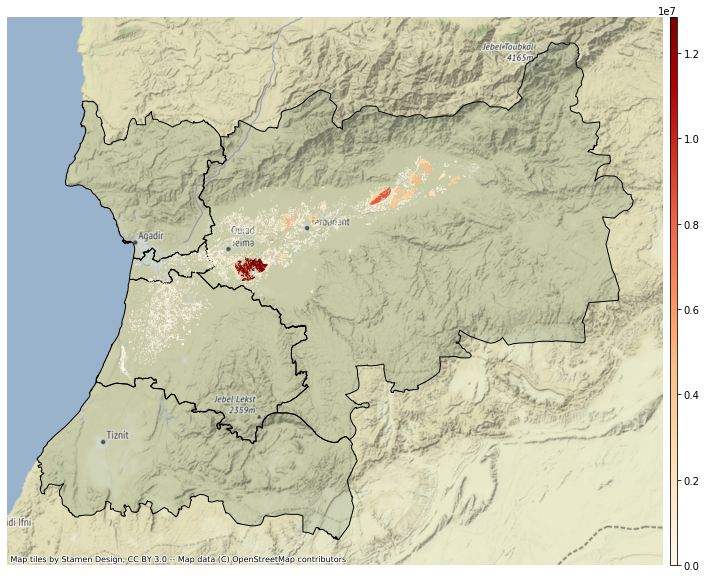

In [166]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='energy demand', ax=ax, cmap='OrRd', legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()

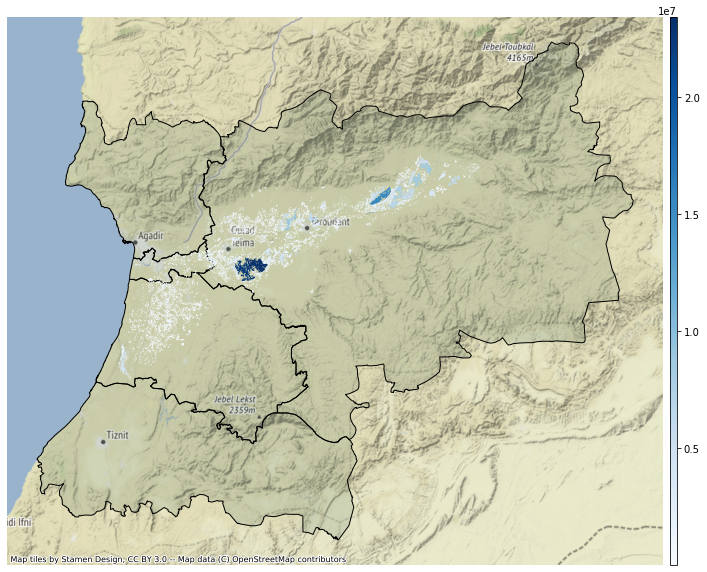

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='water demand', ax=ax, cmap='Blues', legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()

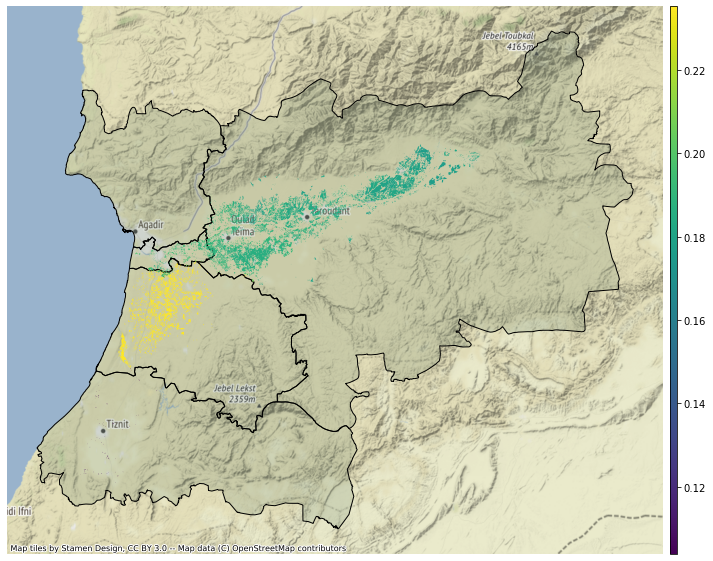

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='lcoe', ax=ax, legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()

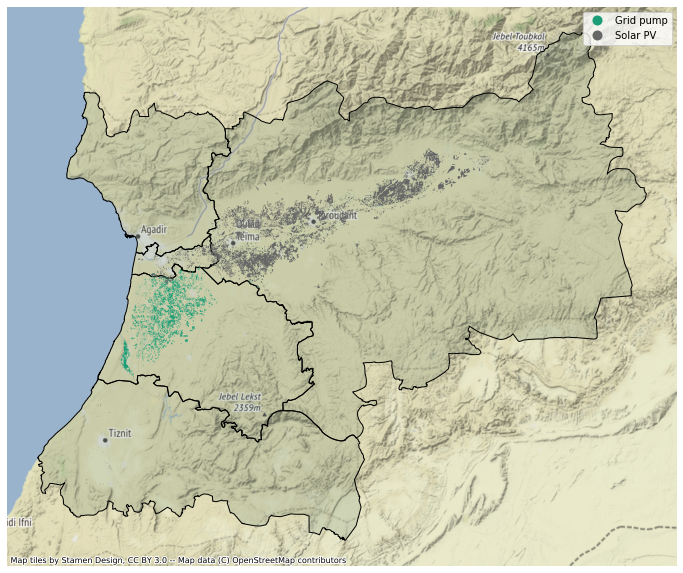

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='least_cost_technology', categorical=True, cmap='Dark2', ax=ax, legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()
# fig.savefig('testPlot.png', dpi=300)

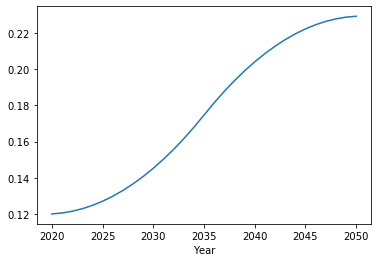

In [180]:
iyear = 2020
eyear = 2050
cp = 0.12
rate = -0.7
rates = {2020: 0, 2030: rate*0.3, 2040: rate, 2050: rate*1.3}
curve = create_learning_curve(iyear, eyear, cp, rates, 'polynomial')
curve.plot()